# EV State-Space Model

This  notebook is used to reproduce the State Space Model of aggregateed EV for frequency regulation.

Running on Jinning's local machine, in the env "ev".

Working notes:

02/06/2022: the EV data generation is completed. It looks weired, we may need update it later on.


## EV data

### Define parameters

The EV parameters are defined as two types. Type I follows uniform distribution, which is stored in a Dict `ev_param`. Type II follows normal distribution, which is stored in a pd.DataFrame `ev_pdf`.

The data are cited from:

M. Wang et al., "State Space Model of Aggregated Electric Vehicles for Frequency Regulation," in IEEE Transactions on Smart Grid, vol. 11, no. 2, pp. 981-994, March 2020, doi: 10.1109/TSG.2019.2929052.

In [1]:
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from hmmlearn import hmm

import logging
logger = logging.getLogger(__name__)


def find_x(x, soc_intv):
    out = -1
    for idx in soc_intv.keys():
        if x > soc_intv[idx][0] and x <= soc_intv[idx][1]:
            out = idx
    return out


def update_xl(inl_input):
    """
    Update x series.
    columns:
    ['socx', 'xl', 'u', 'u0', 'ctrl', 'ts']
        0,    1,    2,    3,    4,       5
    """
    inl = inl_input.copy()
    x = inl[0]
    dc = inl[1].copy()
    u = inl[2]
    u0 = inl[3]
    state = inl[4]
    ts = inl[5]
    # --- Continuous online ---
    if u*u0 == 1:
        if len(dc[0]) == 0:
            dc[0] = [state]
            dc[1] = [x]
            dc[2] = [ts]
        else:
            dc[0].append(state)
            dc[1].append(x)
            dc[2].append(ts)
    # --- offline -> online ---
    elif (1-u0)*u == 1:
        if len(dc[0]) == 0:
            dc[0] = [state]
            dc[1] = [x]
            dc[2].append(ts)
        else:
            dc[0].append([state])
            dc[1].append([x])
            dc[2].append([ts])
    return dc


def safe_div(x, y):
    if y == 0:
        return 0
    else:
        return x/y


class ev_ssm():
    """
    EV State Space Model.

    EV parameters:
    Pc, Pd, nc, nd, En follow uniform distribution.
    soci, socd, ts, tf follows normal distribution.

    Attributes
    ----------
    xtab: pandas.DataFrame
        EV states table, only online EVs are counted.
    ne: int
        Number of online EVs
    N: int
        Number of total EVs
    Np: int
        SSM update cycle.
    ev: pandas.DataFrame
        EV dataset
        u: online status
        u0: previous online status
        socx: SOC interval
        xl: list of lists, [[states], [socx], [t]]
    ts: float
        current time (unit: 24H)

    Notes
    -----
    ev_ufparam:
        Pl: rated charging/discharging power (kW) lower bound
        Pu: rated charging/discharging power (kW) upper bound
        nl: charging/discharging efficiency lower bound
        nu: charging/discharging efficiency upper bound
        Enl: Battery capacity (kWh) lower bound
        Enu: Battery capacity (kWh) upper bound
        socl: Minimum SoC value
        socu: Maximum SoC value
    ev_nfparam:
        soci: initial SoC
        socd: demanded SoC
        ts1: start charging time, [24H]
        ts2: start charging time, [24H]
        tf1: finish charging time, [24H]
        tf2: finish charging time, [24H]
    """

    def find_socx(self):
        self.ev['socx'] = self.ev['soc'].apply(lambda x: find_x(x, self.soc_intv))

    def report(self):
        """
        Report EVA.
        """
        # --- EV summary info ---
        self.En = self.ev.En.sum()/1e3
        self.wEn = np.sum(self.ev.u * self.ev.En)/1e3
        # --- report info ---
        msg1 = f"{self.name} initialize:\n"
        msg_time = f'ts={np.round(self.ts, 4)}[H]\n'
        msg_ev = f"{self.N} EVs, {self.ne} online, Total En={self.En.round(2)} MWh, SoC intervals: {len(self.soc_intv)}\n"
        msg_soc = f"Online En={self.wEn.round(2)} MWh, mean SoC={100*self.ev.soc.mean().round(2)}%"
        logger.warning(msg1 + msg_time + msg_ev + msg_soc)

    def g_ts(self, ts):
        """
        Update time and time series.
        """
        if ts - self.ts < 1e-6:
            logger.warning(f"{self.name}: {ts}[H] is too close to current time={self.ts}[H]")
        else:
            self.tss.append(ts)
            ts = ts if ts < 24 else ts-24
        return ts

    def __init__(self, ts=0, N=20000, step=4,
                 tp=100, seed=None, name="EVA"):
        """
        Parameters
        ----------
        ts: float
            Current time in hour, [0, 24].
        N: int
            Number of EVs
        tp: int
            SSM update period (second).
        step: int
            Step size in seconds.
        seed: int
            Random seed. ``None`` for random.
        """
        # --- 1. init ---
        self.name = name
        self.N = N
        self.step = step
        self.Np = int(tp / step)
        self.seed = seed
        np.random.seed(self.seed)
        # --- 1a. uniform distribution parameters range ---
        self.ev_ufparam = dict(Ns=20,
                               Pl=5.0, Pu=7.0,
                               nl=0.88, nu=0.95,
                               Enl=20.0, Enu=30.0,
                               socl=0, socu=1)
        #  --- 1b. normal distribution parameters range ---
        self.ev_pdf_name = ['soci', 'socd', 'ts1', 'ts2', 'tf1', 'tf2']
        self.ev_pdf_data = {'mean':     [0.3,    0.8,    -6.5,   17.5,   8.9,    32.9],
                            'var':      [0.05, 0.03, 3.4, 3.4, 3.4, 3.4],
                            'lb':       [0.2, 0.7, 0.0, 5.5, 0.0, 20.9],
                            'ub':       [0.4, 0.9, 5.5, 24.0, 20.9, 24.0],
                            'info':  ['initial SoC', 'demanded SoC',
                                      'start charging time 1', 'start charging time 2',
                                      'finish charging time 1', 'finish charging time 2']}
        self.ts = ts
        self.tss = [ts]
        self.build(ts=ts)
        self.report()

        # --- SSM ---
        # --- input: AGC signal ---

        # --- output: estimated FRC ---
        self.prumax = 0
        self.prdmax = 0

    def build(self, ts):
        """
        Build the ev DataFrame.

        Returns
        -------
        ev: pandas.DataFrame
            EV dataset
        """
        self.socl = self.ev_ufparam['socl']
        self.socu = self.ev_ufparam['socu']

        #  --- 1a. uniform distribution parameters range ---
        unit = self.ev_ufparam['socu']/self.ev_ufparam['Ns']
        self.soc_intv = {}
        decimal = 4
        for i in range(self.ev_ufparam['Ns']):
            intv_single = [np.around(i*unit, decimal), np.around((i+1)*unit, decimal)]
            self.soc_intv[i] = intv_single
        self.Ns = self.ev_ufparam['Ns']
        ev_pdf = pd.DataFrame(data=self.ev_pdf_data, index=self.ev_pdf_name).transpose()
        self.ev_nfparam = ev_pdf.to_dict()

        # --- 1c. generate EV dataset ---
        self.ev = pd.DataFrame()

        #  data from uniform distribution
        cols = ['Pc', 'Pd', 'nc', 'nd', 'En']
        cols_bound = {'Pc':   ['Pl', 'Pu'],
                      'Pd':   ['Pl', 'Pu'],
                      'nc':   ['nl', 'nu'],
                      'nd':   ['nl', 'nu'],
                      'En':    ['Enl', 'Enu']}
        for col in cols:
            idxl = cols_bound[col][0]
            idxh = cols_bound[col][1]
            self.ev[col] = np.random.uniform(
                low=self.ev_ufparam[idxl],
                high=self.ev_ufparam[idxh],
                size=self.N)

        #  data from normal distribution
        # soci, socd
        for col in self.ev_pdf_name:
            self.ev[col] = stats.truncnorm(
                (ev_pdf[col]['lb'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                (ev_pdf[col]['ub'] - ev_pdf[col]['mean']) / ev_pdf[col]['var'],
                loc=ev_pdf[col]['mean'], scale=ev_pdf[col]['var']).rvs(self.N)

        # ts1, ts2, tf1, tf2
        et = self.ev.copy()
        r1 = 0.5  # ratio of t1
        tp1 = self.ev[['ts1', 'tf1']].sample(n=int(et.shape[0]*r1), random_state=2021)
        tp2 = self.ev[['ts2', 'tf2']].sample(n=int(et.shape[0]*(1-r1)), random_state=2021)
        tp = pd.concat([tp1, tp2], axis=0).reset_index(drop=True).fillna(0)
        tp['ts'] = tp['ts1'] + tp['ts2']
        tp['tf'] = tp['tf1'] + tp['tf2']
        check = tp.ts > tp.tf
        row_idx = tp[check].index
        mid = tp.tf.iloc[row_idx].values
        tp.tf.iloc[row_idx] = tp.ts.iloc[row_idx]
        tp.ts.iloc[row_idx] = mid
        check = tp.ts > tp.tf
        self.ev['ts'] = tp['ts']
        self.ev['tf'] = tp['tf']
        self.ev['u'] = 1

        # Initialize delta power
        self.ev['dP'] = 0

        self.states = list(itertools.product([1, 0, -1], self.soc_intv.keys()))
        self.states_str = [str(s[1])+'S'+str(s[0]) for s in self.states]

        # --- update soc interval and online status ---
        # --- ev online status: u0 as u ---
        self.ev['u0'] = 0
        self.g_u()
        self.ev['u0'] = self.ev.u

        # soc is initialzied considering random behavior
        self.ev['soc'] = self.ev[['soci', 'ts', 'Pc', 'nc', 'En', 'tf']].apply(
            lambda x: x[0] + (min(ts-x[1], x[5]-x[1]))*x[2]*x[3]/x[4] if ts > x[1] else x[0], axis=1)
        self.ev['soc'] = self.ev['soc'].apply(lambda x: min(x, self.socu))

        # Initiallize control signal
        self.ev['ctrl'] = self.ev['u']  # initially use cahrging signal
        self.g_ctrl(is_charge=False)

        self.find_socx()
        self.g_x()

        ev_cols = ['u', 'u0', 'Pc', 'Pd', 'nc', 'nd', 'En', 'soc',
                   'soci', 'socd', 'socx', 'ts', 'tf', 'ctrl', 'dP']
        self.ev = self.ev[ev_cols]

        # initialize x series
        self.ev['xl'] = [[[], [], []]] * self.N
        self.ne = self.ev.u.sum()

        self.ssm_basic()
        return True

    def g_u(self):
        """
        Update online status of EV at given time.
        """
        self.ev['u0'] = self.ev.u.astype(int)
        self.ev['u'] = (self.ev.ts <= self.ts) & (self.ev.tf >= self.ts)
        self.ev['u'] = self.ev['u'].astype(int)
        self.ne = self.ev.u.sum()
        return True

    def g_x(self):
        """
        Update EV x and SSM x.

        In the output table, columns stand for soc interval, rows stand for charging status.

        0 for charging, 1 for idle, 2 for discharging.

        Returns
        -------
        xtab: pd.DataFrame
            Table of SSM status
        rtab: pd.DataFrame
            Table of SSM status, by percentage of **online EVs**
        """
        # --- find single EV socx ---
        self.ev['socx'] = self.ev['soc'].apply(lambda x: find_x(x, self.soc_intv))

        # --- find SSM X ---
        states = self.ev[['ctrl2', 'socx', 'u']].apply(lambda x: (x[0], x[1]) if x[2] else (-1, -1), axis=1)
        res = dict(states.value_counts())
        self.xtab = pd.DataFrame(columns=range(self.Ns), index=[0, 1, 2], data=0)
        for key in res.keys():
            if key[1] > -1:
                self.xtab.loc[key[0], key[1]] = res[key]
        self.xtab.fillna(0, inplace=True)

        self.rtab = self.xtab.div(self.ne)
        return True

    def ssm_basic(self):
        """
        Build SSM B, C, D matrix.
        """
        B1 = -1 * np.eye(self.Ns)
        B2 = np.eye(self.Ns)
        B3 = np.zeros((self.Ns, self.Ns))
        self.B = np.vstack((B1, B2, B3))

        C1 = np.zeros((self.Ns, self.Ns))
        C2 = -1 * np.eye(self.Ns)
        C3 = np.eye(self.Ns)
        self.C = np.vstack((C1, C2, C3))

        # P average
        kde = stats.gaussian_kde(self.ev.Pc)
        Pave = 0  # TODO: consider Pave as an attribute
        step = 0.01
        for Pl in np.arange(self.ev.Pc.min(), self.ev.Pc.max(), step):
            Pave += (kde.integrate_box(Pl, Pl+step)) * (Pl + 0.05 * step)

        D1 = -1 * np.ones((1, self.Ns))
        D2 = np.zeros((1, self.Ns))
        D3 = np.ones((1, self.Ns))
        # TODO: should use online numbers?
        self.D = Pave * self.N * np.hstack((D1, D2, D3))
        return True

    def run(self, tf=10, is_charge=False, is_record=False):
        """
        Run the ev aggregator from ``ts`` to ``tf``.

        Parameters
        ----------
        tf: int
            end time (hour with decimals).
        is_charge: bool
            True for charging all EVs that are not fully charged,
            False for randomly discharge part of fully charged EVs.
        is_record: bool
            True for recording the EV status in a series, False for not recording.
            Set as False can speed up the simulation.
        """
        t_step = self.step / 3600
        if tf - self.ts < 1e-3:
            logger.warning(f"{self.name}: end time {tf}[H] is too close to start time {self.ts}[H],"
                           "simulation will not start.")
        else:
            for t in tqdm(np.arange(self.ts+t_step, tf, t_step), desc=f'{self.name} MCS'):
                self.ts = self.g_ts(t)
                self.g_u()  # update online status
                self.g_ctrl(is_charge=is_charge)  # update control signal

                # --- update soc interval and online status ---
                # charging/discharging power, kW
                self.ev['dP'] = self.ev[['Pc', 'Pd', 'nc', 'nd', 'ctrl', 'u']].apply(
                    lambda x: x[0]*x[2]*x[5] if x[4] >= 0 else -1*x[1]*x[3]*x[5], axis=1)
                # --- update an revise SoC ---
                self.ev['soc'] = self.ev.soc + t_step * self.ev['dP'] / self.ev['En']
                self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x < self.socu else self.socu)
                self.ev['soc'] = self.ev['soc'].apply(lambda x: x if x > self.socl else self.socl)

                # update x
                self.find_socx()
                self.g_x()

                if is_record:
                    self.g_xl()
        return True

    def g_A(self, is_run=True, is_update=False, **kwargs):
        """
        Run the EV_SSM and build matrix T and E with recent ``Np`` records.
        Remember to set ``is_run=True`` to get valid data for T and E.

        Parameters
        ----------
        is_run: bool
            `True` for build T and E after running the simulation,
            `False` for build T and E with existing data ``ev['xl']``.
        is_update: bool
            `True` for estimate T and E with recent data, `False` for all data
        **kwargs:
            keyword arguments for `run()`.

        Returns
        -------
        Tf: np.ndarray
            Transition matrix (3 by 3) by frequency
        Ef: np.ndarray
            Emission matrix (3 by Ns) by frequency
        Tm: np.ndarray
            Transition matrix (3 by 3) by HMM
        Em: np.ndarray
            Emission matrix (3 by Ns) by HMM

        Notes
        -----
        Transition matrix T:
        col: x(t+1); row: x(t)

        Emmision matrix E:
        col: socx, 0-19; row: states, 0, 1, 2 (CS, IS, DS)
        """
        # --- run simulation ---
        if is_run:
            self.run(**kwargs)

        logger.warning(f"{self.name}: Estimate SSM matrix")
        # --- gather results ---
        self.seq = []
        self.states = []
        self.txl = []
        for item in self.ev.xl.tolist():
            if len(item[0]) > 0:
                self.seq.append(item[1])
                self.states.append(item[0])
                self.txl.append(item[2])
        # --- keep recent data ---
        if is_update:
            self.seq = self.seq[-self.Np:]
            self.states = self.states[-self.Np:]
            self.txl = self.txl[-self.Np:]
        
        has_old = False
        if all(hasattr(self, attr) for attr in ['Tf', 'Ef', 'Tm', 'Em']):
            Ef0 = self.Ef.copy()
            Tf0 = self.Tf.copy()
            Em0 = self.Em.copy()
            Tm0 = self.Tm.copy()
            has_old = True

        # --- estimation by frequency ---
        Ef = np.zeros((3, self.Ns))
        for t, s in zip(self.states, self.seq):
            for i in range(len(t)):
                Ef[t[i], s[i]] += 1
        rf = Ef.sum(axis=1)
        rf = np.where(rf < 0.1, 1, rf)
        self.Ef = Ef / rf[:, None]

        Tf = np.zeros((3, 3))
        for state in self.states:
            for i in range(len(state)-1):
                Tf[state[i]][state[i+1]] += 1
        ra = Tf.sum(axis=1)
        ra = np.where(ra < 0.1, 1, ra)
        self.Tf = Tf / ra[:, None]

        # --- partially updata ---
        if has_old:
            self.Ef = (0.9*self.Ef + 0.1*Ef0)
            self.Tf = (0.9*self.Tf + 0.1*Tf0)

        # revise Tf and Ef if IS and DS are no valid data
        # TODO: the revise is OK?
        if np.sum(self.Tf[1, :]) <= 0.01:
            self.Tf[1] = [0, 0.9, 0.1]
            logger.warning(f"{self.name}: IS is not valid, revise Tf[1]")
        if np.sum(self.Tf[2, :]) <= 0.01:
            self.Tf[2] = [0, 0.9, 0.1]
            logger.warning(f"{self.name}: IS is not valid, revise Tf[2]")
        if np.sum(self.Ef[1, :]) <= 0.01:
            self.Ef[1, self.Ns-1] = 1
            logger.warning(f"{self.name}: DS is not valid, revise Ef[1]")
        if np.sum(self.Ef[2, :]) <= 0.01:
            self.Ef[2, self.Ns-1] = 1
            logger.warning(f"{self.name}: DS is not valid, revise Ef[2]")

        # --- estimation by HMM ---
        self.hmdl = hmm.MultinomialHMM(n_components=3, n_iter=10,
                                       params='ste', init_params='')
        self.hmdl.n_features = self.Ns
        self.hmdl.transmat_ = self.Tf
        self.hmdl.emissionprob_ = self.Ef
        self.hmdl.startprob_ = np.array(self.xtab.sum(axis=1)/self.xtab.sum().sum())
        X = np.concatenate(self.seq).reshape(-1, 1)
        length = [len(item) for item in self.seq]
        self.hmdl.fit(X, length)
        self.Tm = self.hmdl.transmat_
        self.Em = self.hmdl.emissionprob_
        if has_old:
            self.Tm = (0.9*self.Tm + 0.1*Tm0)
            self.Em = (0.9*self.Em + 0.1*Em0)
        return True

    def g_xl(self):
        """
        Update EV x series.
        """
        self.ev['tnow'] = self.ts
        col = ['socx', 'xl', 'u', 'u0', 'ctrl2', 'tnow']
        self.ev['xl'] = self.ev[col].apply(update_xl, axis=1)
        self.ev.drop(['ctrl2', 'tnow'], axis=1, inplace=True)
        return True

    def g_ctrl(self, is_charge=False):
        """
        Generate the charging signal.
        """
        # --- default signal is charging for all ---
        # TODO: replace with SSM later on
        # --- charging signal ---
        self.ev['ctrl'] = self.ev.u  # charge all online cars
        if is_charge:
            # charged to demanded soc EVs set as idle state
            self.ev['ctrl'] = self.ev[['soc', 'ctrl', 'socd']].apply(
                lambda x: 0 if x[0] >= x[2] else x[1], axis=1)
        else:
            # already max(0.95, socd) EVs are randomly discharging
            self.ev['ctrl'] = self.ev[['ctrl', 'u', 'soc', 'socd']].apply(
                lambda x: np.random.choice([0, -1], p=[0.9, 0.1]) if x[1]*(x[2] > max(x[3], 0.95)) else x[0], axis=1)
        # --- revise control ---
        # low charged EVs are FORCED charging
        self.ev['ctrl'] = self.ev[['soc', 'ctrl']].apply(
            lambda x: 1 if x[0] <= 0.1 else x[1], axis=1)
        # offline EVs set as idle state
        self.ev['ctrl'] = self.ev[['ctrl', 'u']].apply(
            lambda x: x[0]*x[1], axis=1)
        # format
        self.ev['ctrl'] = self.ev['ctrl'].astype(int)
        # reformat to [0, 1, 2]
        self.ev['ctrl2'] = self.ev['ctrl'].replace({1: 0, 0: 1, -1: 2})
        return True

    def e_res(self, sp, n=1, mode='hmm'):
        """
        Estimate the EV_SSM status, stores in attribute pd.DataFrame ``res``

        Parameters
        ----------
        sp: numpy.array, shape = (3, 1)
            [CS, DS, IS], proportion of states of the initial time step.
        n: int
            number of steps.
        mode: str
            'hmm' stands for Hidden Markov Model,
            'freq' stands for frequency estimation.
        """
        if mode == 'hmm':
            E = self.Em
            T = self.Tm
        elif mode == 'freq':
            E = self.Ef
            T = self.Tf
        else:
            raise ValueError(f"{mode} is not supported.")

        Edf = pd.DataFrame(columns=range(self.Ns),
                           index=[0, 1, 2], data=E)
        # --- out ---
        for i in range(n):
            sp = np.matmul(T.T, sp)
            self.eres = Edf.mul(sp, axis=0)
        return self.eres

    def reset(self):
        """
        Reset the pd.DataFrame ``ev`` to the initial time.
        """
        self.tss = [self.tss[0]]
        self.ts = self.tss[0]
        col = ['u', 'u0', 'Pc', 'Pd', 'nc', 'nd', 'En', 'soc', 'soci', 'socd', 'socx',
               'ts', 'tf', 'ctrl', 'dP', 'xl']
        self.ev = self.ev[col]
        self.ev['ctrl2'] = self.ev['ctrl'].replace({1: 0, 0: 1, -1: 2})
        self.ev['dP'] = 0
        self.ev['xl'] = [[[], [], []]] * self.N
        self.ev['u0'] = 0
        self.g_u()
        self.ev['u0'] = self.ev.u

        self.find_socx()
        self.g_x()

        # initialize x series
        self.ev['xl'] = [[[], [], []]] * self.N
        self.ne = self.ev.u.sum()
        logger.warning(f"{self.name}: Reset to {self.ts}[H]")
        return True


Initialize EV and build SSM matrix

In [2]:
sse = ev_ssm(N=5000, ts=10, name='SSE1', seed=2021)
sse.g_A(tf=10.05, is_run=True, is_update=False,
        is_charge=False, is_record=True)

SSE1 initialize:
ts=10[H]
5000 EVs, 955 online, Total En=125.19 MWh, SoC intervals: 20
Online En=23.81 MWh, mean SoC=64.0%
SSE1 MCS: 100%|██████████| 45/45 [00:10<00:00,  4.31it/s]
SSE1: Estimate SSM matrix


True

Run to same end point

In [3]:
sse2 = ev_ssm(N=5000, ts=10, name='SSE2', seed=2021)
sse2.run(tf=10.05, is_charge=False, is_record=False)

SSE2 initialize:
ts=10[H]
5000 EVs, 955 online, Total En=125.19 MWh, SoC intervals: 20
Online En=23.81 MWh, mean SoC=64.0%
SSE2 MCS: 100%|██████████| 45/45 [00:06<00:00,  6.43it/s]


True

Estiamte the state from the same startpoint

In [4]:
sse.reset()
x0 = sse.rtab.sum(axis=1).values
res = sse.e_res(x0, n=len(sse2.tss)-1, mode='hmm')

SSE1: Reset to 10[H]


In [5]:
sse.rtab.round(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0031,0.0052,0.0021,0.001,0.0052,0.0021,0.0042,0.0031,0.001,0.0021,0.0021,0.0,0.0,0.0021,0.0000
1,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0000,0.8817
2,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0000,0.0848


In [6]:
res.round(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0009,0.0023,0.0052,0.0026,0.0006,0.0057,0.002,0.0053,0.0017,0.001,0.0025,0.0017,0.0,0.0,0.0021,0.0000
1,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0000,0.8698
2,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,0.0000,0.0967


SSE0 initialize:
ts=0[H]
10000 EVs, 0 online, Total En=249.93 MWh, SoC intervals: 20
Online En=0.0 MWh, mean SoC=30.0%
SSE0: 0.0[H] is too close to current time=0[H]


(0.0, 24.0)

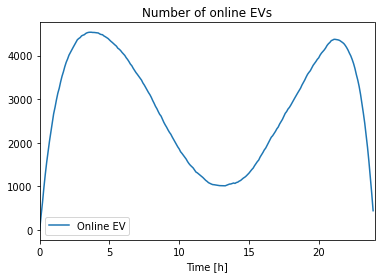

In [7]:
# --- plot online EV numbers ---
sse = ev_ssm(N=10000, ts=0, name='SSE0', seed=2021)
time = np.arange(0, 24, 0.1)
num = []
for t in time:
    sse.ts = sse.g_ts(t)
    sse.g_u()
    num.append(sse.ne)

fig, ax = plt.subplots()
ax.plot(time, num)
ax.set_title('Number of online EVs')
ax.set_xlabel('Time [h]')
ax.legend(['Online EV', 'Online capacity'])
ax.set_xlim(0, 24)

In [8]:
# # --- plot online EV numbers ---
# # time = np.arange(0, 24, 0.1)
# # num = []
# # for t in time:
# #     sse.g_u(t)
# #     num.append(sse.ne)

# # fig, ax = plt.subplots()
# # ax.plot(time, num)
# # ax.set_title('Number of online EVs')
# # ax.set_xlabel('Time [h]')
# # ax.legend(['Online EV', 'Online capacity'])
# # ax.set_xlim(0, 24)

# # update g_x()

# # # reset sse
# # sse.reset(tnow=10)
# # sse.ev

# # --- Analytical method ---
# data = sse.ev.copy()
# data['dsc'] = data.Pc * data.nc / data.En / 6
# data['dsd'] = data.Pc * data.nc / data.En / 1
# data[['dsc', 'dsd']].plot(kind='kde')

# kde = stats.gaussian_kde(data.dsc)
# for i in range(-1,18,1):
#     lb = 0.05+0.05*i
#     ub = 0.1+0.05*i
#     ires = kde.integrate_box(lb, ub)
#     # print(np.round(ires, 4))

In [9]:
# xdf = pd.DataFrame(xres)
# from hmmlearn import hmm
# gen_model = hmm.GaussianHMM(n_components=60, covariance_type="full")


# sse.reset(tnow=0)
# xres = []
# xres.append(sse.x.values())
# for t in np.arange(0, 24, 300/3600):
#     sse.act(t=300, tnow=t)
#     xres.append(sse.x.values())
# xdf = pd.DataFrame(xres)


# gen_model.fit(pd.concat([xdf]*100).reset_index(drop=True))
# gen_model.predict_proba(xdf.iloc[2].values.reshape(1, -1))

## SSM Matrix

In [10]:
# get the x res by iterate EV from t=0 to t=14.01
# sse.reset(tnow=0)
# x_res = []
# for i, t in enumerate(np.arange(0, 14.01, 1/12)):
#     sse.act(t=300, tnow=t)
#     x_res.append(sse.x.tolist())

# pd.DataFrame(x_res).plot(legend=True)

## Simulation

Issues: how to integerate the SSM when using ADNES?

flow_chart:
```{python}
prep grid data:
ADNES: topology,  gen. limits, ramp. limits, line limits,
Outside: gen. cost, ramp. cost,

for $t_{OPF}$ in T (interval: 5min; total: 1h; [n=12]):
    aggregate EV data (from SSM), generate $PR_{e,i,u,t}$
    Do OPF, generate $PG_{i, t}$, $PR_{g, i, u, t}$, $PR_{g, i, d, t}$

    for t in $t_{OPF}$ (interval: 4s; total: 5min; [n=75]):
        Update data into dynamic system:
            # Note, constant power model should be used in TDS.
            # Use TimeSeries as the load. 
            power change: TGOV1.paux0
            load change: 

        Run TDS: generate SFR mileage
```

Co-Sim list:
```{python}
for $t_{OPF}$ in T:
    EVA report $pru_{max}$ $prd_{max}$, eqn xxx
    TCC do OPF, eqn xxx
    Assign dispatch signal to generation units

    for t in $t_{AGC}$:
        Assign AGC signal to AGC units
        Run TDS
```